Like `minimal_api_tutorial.ipynb`, this fits a simple MLP and then trains it while auto-batching over 
minibatches and then simultaneously training with different step sizes and momentum constants. But unlike 
that other notebook, this uses all the features of Numbat without trying to restrict to some small set. 

In [2]:
# import stuff
import numbat as nb
import jax
from jax import numpy as jnp
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [ ]:
# let's start by loading my favorite MNIST and convert into ntensor format
fmnist = fetch_openml(data_id=40996, as_frame=False, parser='liac-arff')

In [3]:
# convert the data into ntensor format
batch, height, width, cat, hidden, minibatch = nb.axes()
data   = jnp.reshape(fmnist["data"],[70000,28,28])/255.0
x      = nb.ntensor(data, batch, height, width)
y      = nb.ntensor(fmnist["target"].astype(int), batch)

In [4]:
print(x.shape)

{batch:70000, height:28, width:28}


In [5]:
print(y.shape)

{batch:70000}


In [6]:
def predict(params:dict[str,nb.ntensor], x:nb.ntensor)->nb.ntensor:
    "Given an ntensor for a SINGLE input and a parameter dictionary, compute a single output."
    assert x.axes == {width, height}
    assert params['w1'].axes == {width, height, hidden}
    assert params['b1'].axes == {hidden}
    assert params['w2'].axes == {hidden, cat}
    assert params['b2'].axes == {cat}
    
    H = nb.relu(params['w1'] @ x + params['b1'])
    out = params['w2'] @ H + params['b2']
    
    assert H.axes == {hidden}
    assert out.axes == {cat}
    return out

def logistic_loss(pred:nb.ntensor, y:nb.ntensor)->jnp.ndarray:
    "Given an ntensor of predictions and a SINGLE output, compute loss."
    assert pred.axes == {'cat'}
    assert y.axes == set()
    
    loss = nb.lift(jax.nn.logsumexp,'cat ->')(pred) - pred(cat=y)

    assert loss.axes == set()
    return loss

In [13]:
n_hidden = 128
params = dict()
params['w1'] = nb.randn(width=28,height=28,hidden=n_hidden)
params['b1'] = nb.randn(hidden=n_hidden)
params['w2'] = nb.randn(hidden=n_hidden, cat=10)
params['b2'] = nb.randn(cat=10)

predict(params, x(batch=5))

vmap called: in_axes=frozenset({Axis('hidden')})
vmap called: in_axes=frozenset({Axis('hidden')})
vmap called: in_axes=frozenset({Axis('cat')})


<ntensor {cat:10} [  84.89314    95.12175   -45.901123 -132.94118   118.38216  -174.13913
 -195.02495  -226.39972    72.14223  -144.96423 ]>

In [15]:
# loss is Numbat scalar
logistic_loss(nb.ntensor(jnp.zeros(10), 'cat'), y(batch=0))

vmap called: in_axes=frozenset()
vmap called: in_axes=frozenset()


<ntensor {} 2.3025851>

In [18]:
def estimate_loss(params:dict[str,nb.ntensor], key:nb.ntensor)->jnp.ndarray:
    "Given dict of params and Jax PRNGKey, draw random input and output, make predictions, compute loss"
    b = nb.random_int(key, 0, 70000)
    my_x = x(batch=b)
    my_y = y(batch=b)
    pred = predict(params, my_x)
    return logistic_loss(pred, my_y)


#key = jax.random.PRNGKey(0)
key = nb.PRNGKey(0,'prngkey')
estimate_loss(params, key)



<ntensor {} 106.76195>

In [19]:
def estimate_loss_batched(params:dict[str,nb.ntensor], key:nb.ntensor)->jnp.ndarray:
    """Given dict of params and (ntensor) prngkey, draw a BUNCH of inputs, estimate all losses, take mean."""
    keys = nb.random_split(key, 128, 'minibatch')
    losses = nb.vmap(estimate_loss, {'minibatch'})(params, keys)
    return nb.mean(losses)

estimate_loss_batched(params, key)

<ntensor {} 122.938934>

In [20]:
g = nb.grad(estimate_loss_batched)(params, key)
{key: g[key].shape for key in g}

{'b1': ShapeDict(hidden=128),
 'b2': ShapeDict(cat=10),
 'w1': ShapeDict(width=28, height=28, hidden=128),
 'w2': ShapeDict(hidden=128, cat=10)}

In [1]:
def sgd(params:dict[str,nb.ntensor], step, momentum, scale):
    key = nb.PRNGKey(0,'prngkey')
    avg_loss = 0
    grad_fun = nb.value_and_grad(estimate_loss_batched)
    avg_g = {name:params[name]*0 for name in params}
    params = {name:params[name]*scale for name in params}
    
    def next(i, key, params, avg_loss, avg_g):
        key, subkey = nb.random_split(key)
        loss, g = grad_fun(params, subkey)
        beta = nb.maximum(momentum, 1/(1+i))
        avg_g = {name: (1-beta)*avg_g[name] + beta*g[name] for name in params}
        params = {name:params[name] - step*(avg_g[name]) for name in params}        
        alpha = nb.maximum(.05, 1/(i+1))
        avg_loss = (1-alpha)*avg_loss + alpha*loss
        return key, params, avg_loss, avg_g
    
    next = jax.jit(next)
    
    for i in range(100):
        key, params, avg_loss, avg_g = next(i, key, params, avg_loss, avg_g)
    return params, avg_loss

optimized_params, avg_loss = sgd(params, .01, .1, 1)
avg_loss

NameError: name 'nb' is not defined

In [30]:
steps = nb.ntensor(2.0**-jnp.arange(0.5, 7, 0.5), 'step')
moms  = nb.ntensor(2.0**-jnp.arange(0, 8, 2), 'mom')
scales = nb.ntensor(2.0**-jnp.arange(0, 5, 3),'scale')
print(f"{steps=}")
print(f"{moms=}")
print(f"{scales=}")

steps=<ntensor {step:13} [0.70710677 0.5        0.35355338 0.25       0.17677669 0.125
 0.08838835 0.0625     0.04419417 0.03125    0.02209709 0.015625
 0.01104854]>
moms=<ntensor {mom:4} [1.       0.25     0.0625   0.015625]>
scales=<ntensor {scale:2} [1.    0.125]>


In [31]:
# batch across all steps sizes and all momentums
_, avg_loss = nb.vmap(sgd, in_axes={'step','mom','scale'})(params, steps, moms, scales)

i=0 i=1 i=2 i=3 i=4 i=5 i=6 i=7 i=8 i=9 i=10 i=11 i=12 i=13 i=14 i=15 i=16 i=17 i=18 i=19 i=20 i=21 i=22 i=23 i=24 i=25 i=26 i=27 i=28 i=29 i=30 i=31 i=32 i=33 i=34 i=35 i=36 i=37 i=38 i=39 i=40 i=41 i=42 i=43 i=44 i=45 i=46 i=47 i=48 i=49 i=50 i=51 i=52 i=53 i=54 i=55 i=56 i=57 i=58 i=59 i=60 i=61 i=62 i=63 i=64 i=65 i=66 i=67 i=68 i=69 i=70 i=71 i=72 i=73 i=74 i=75 i=76 i=77 i=78 i=79 i=80 i=81 i=82 i=83 i=84 i=85 i=86 i=87 i=88 i=89 i=90 i=91 i=92 i=93 i=94 i=95 i=96 i=97 i=98 i=99 i=0 i=1 i=2 i=3 i=4 i=5 i=6 i=7 i=8 i=9 i=10 i=11 i=12 i=13 i=14 i=15 i=16 i=17 i=18 i=19 i=20 i=21 i=22 i=23 i=24 i=25 i=26 i=27 i=28 i=29 i=30 i=31 i=32 i=33 i=34 i=35 i=36 i=37 i=38 i=39 i=40 i=41 i=42 i=43 i=44 i=45 i=46 i=47 i=48 i=49 i=50 i=51 i=52 i=53 i=54 i=55 i=56 i=57 i=58 i=59 i=60 i=61 i=62 i=63 i=64 i=65 i=66 i=67 i=68 i=69 i=70 i=71 i=72 i=73 i=74 i=75 i=76 i=77 i=78 i=79 i=80 i=81 i=82 i=83 i=84 i=85 i=86 i=87 i=88 i=89 i=90 i=91 i=92 i=93 i=94 i=95 i=96 i=97 i=98 i=99 i=0 i=1 i=2 i=3 i=4 

In [14]:
# convert to dataframe for easy plotting
df = nb.dataframe(avg_loss, 'loss', steps, moms, scales)

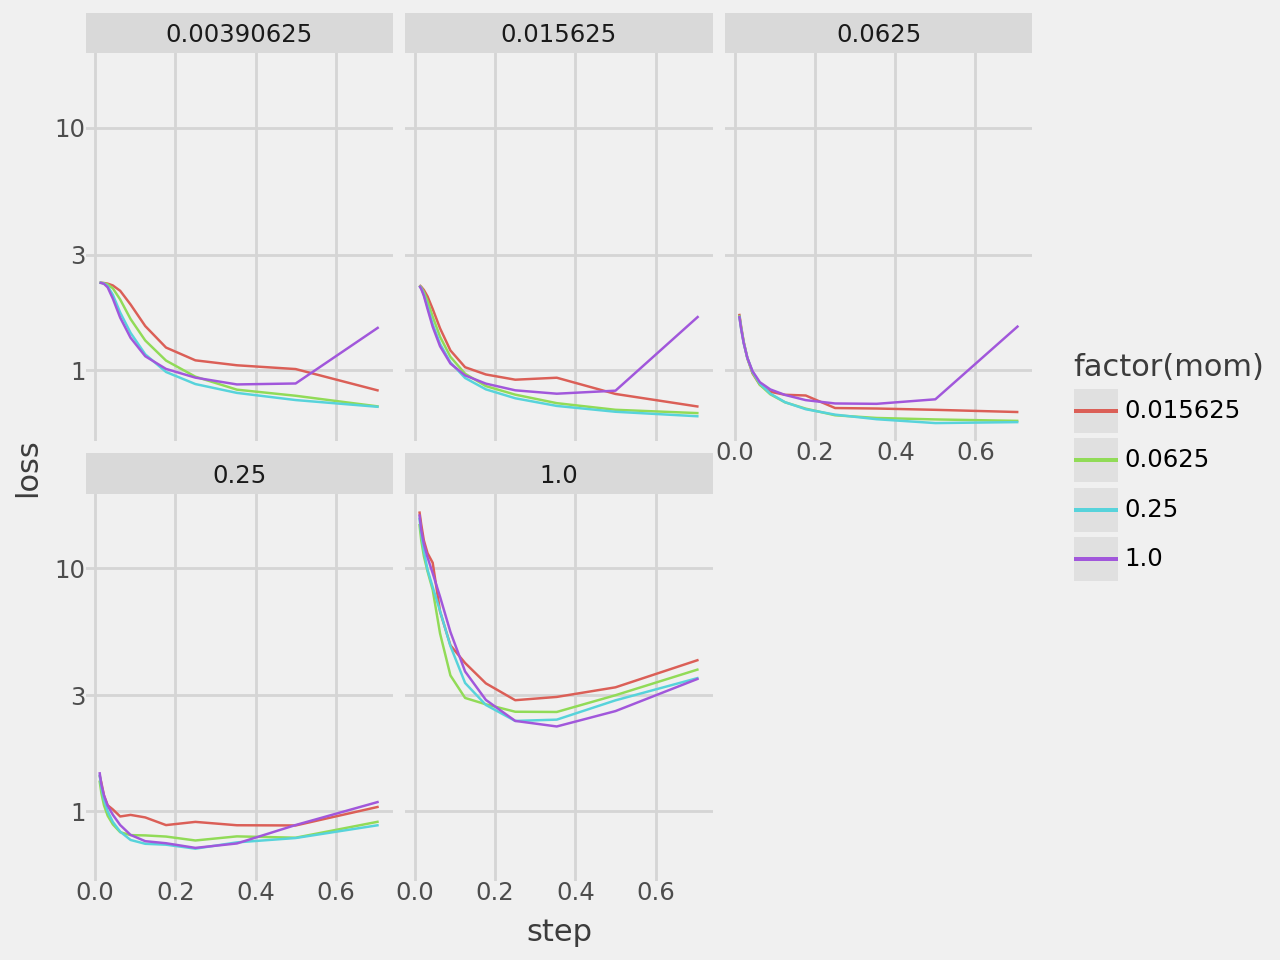

In [15]:
import plotnine as p9

(
        p9.ggplot(df, p9.aes('step', 'loss', color='factor(mom)'))
        + p9.geom_line()
        + p9.theme_538()
        + p9.facet_wrap('scale')
        + p9.labs()
        + p9.scale_y_log10()
 )